# NonLinear SVM
*** Date: 2019-2-2 ***

*** Author:wwt117@163.com ***

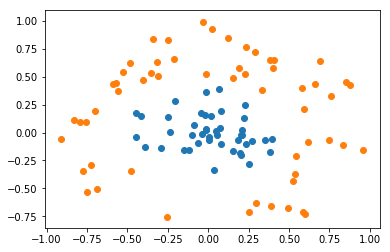

In [2]:
# Visual Data

import matplotlib.pyplot as plt
import numpy as np

def LoadData(fileName):
    """
    Load the dataset and plot the figure
    :param fileName - the name(path) of the data file
    """
    # Open the file
    f = open(fileName)
    
    data = []
    label = []
    
    # Read the data and corresponding labels by lines
    for line in f.readlines():
        temp = line.strip().split('\t')
        data.append([float(temp[0]),float(temp[1])])
        label.append(float(temp[2]))
         
    return data,label

def Visualize(data,label):
    """
    visualize the dataset
    """
    data_plus = []   # class 1
    data_minus = []  # class 2
    for i in range(len(data)):
        if(label[i]>0):
            data_plus.append(data[i])
        else:
            data_minus.append(data[i])
    # convert list to numpy
    data_plus_np = np.array(data_plus)             
    data_minus_np = np.array(data_minus)         
    # plot
    plt.scatter(data_plus_np.T[0],data_plus_np.T[1])
    plt.scatter(data_minus_np.T[0],data_minus_np.T[1])
    plt.show()
    
    
if __name__ == '__main__':
    dataArr,labelArr = LoadData('testSetRBF.txt')                        
    Visualize(dataArr, labelArr)

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import random

class optStruct:
    def __init__(self,data,label,C,toler,kTup):
        self.X = data  # data
        self.labelMat = label # label
        self.C = C # slack value            
        self.tol = toler # tolerant
        self.m = np.shape(data)[0] # the row of the data 
        self.alphas = np.mat(np.zeros((self.m,1))) # alpha 
        self.b = 0 # bias
        self.eCache = np.mat(np.zeros((self.m,2)))
        self.K = np.mat(np.zeros((self.m,self.m))) # initialize the kernel K
        for i in range(self.m):                    # compute all the K
            self.K[:,i] = kernelTrans(self.X,self.X[i,:],kTup)
    
    
def kernelTrans(X,A,kTup):
    """
    convert the low dims to high dims 
    """
    m,n = np.shape(X)
    K = np.mat(np.zeros((m,1)))
    if kTup[0] == 'lin':K = X * A.T
    elif kTup[0] == 'rbf':
        for j in range(m):
            deltaRow = X[j,:] - A
            K[j] = deltaRow * deltaRow.T
        K = np.exp(K/(-1*kTup[1]**2))
    else: raise NameError('核函数无法识别')
    return K
    
    
    
def calcEk(oS,k):
    """
    compute the error 'Ek'
    """
    fXk = float(np.multiply(oS.alphas,oS.labelMat).T*oS.K[:,k] + oS.b)
    Ek = fXk - float(oS.labelMat[k])
    return Ek




def clipAlpha(alpha,H,L):
    """
    limit the bound of alpha
    """
    if alpha > H:
        alpha = H
    if L > alpha:
        alpha = L
    return alpha

def updateEk(oS, k):
    """
    a list that save the temporary error
    """
    Ek = calcEk(oS, k)                                      
    oS.eCache[k] = [1,Ek]                                   


def selectJrand(i,m):
    """
    randomly select a number j, which is different from i
    """
    j = i
    while(j==i):
        j = int(random.uniform(0,m))
    return j

def selectJ(i,oS,Ei):
    """
    A heuristics way to select alpha
    """
    maxK = -1
    maxDeltaE = 0
    Ej = 0
    oS.eCache[i] = [1,Ei]
    validEcacheList = np.nonzero(oS.eCache[:,0].A)[0]
    if (len(validEcacheList)) > 1:
        for k in validEcacheList:
            if k==i:
                continue
            Ek = calcEk(oS,k)
            deltaE = abs(Ei - Ek)
            if(deltaE>maxDeltaE):
                maxK = k
                maxDeltaE = deltaE
                Ej = Ek
        return maxK,Ej
    else:
        j = selectJrand(i,oS.m)
        Ej = calcEk(oS,j)
    return j,Ej
        
    
def innerL(i,oS):
    """
    the optimization of smo algorithm
    """
    # compute the error Ei
    Ei = calcEk(oS,i)
    
    # opt the alpha with a tolerant C
    if ((oS.labelMat[i] * Ei < -oS.tol) and (oS.alphas[i] < oS.C)) or ((oS.labelMat[i] * Ei > oS.tol) and (oS.alphas[i] > 0)):
        
        # using the heuristics way to select a alpha_j and cal the Ej
        j,Ej = selectJ(i,oS,Ei)
        
        # save the alphas
        alpha_i_old = oS.alphas[i].copy(); alpha_j_old = oS.alphas[j].copy();

        # compute the upper bound and low bound
        if(oS.labelMat[i]!=oS.labelMat[j]):
            L = max(0,oS.alphas[j] - oS.alphas[i])
            H = min(oS.C,oS.C + oS.alphas[j] - oS.alphas[i])
        else:
            L = max(0,oS.alphas[j] + oS.alphas[i] - oS.C)
            H = min(oS.C,oS.alphas[j] + oS.alphas[i])
        if L==H:
            print("L==H")
            return 0    
    
        # compute the yite
        eta = 2.0 * oS.K[i,j] - oS.K[i,i] - oS.K[j,j]
        if eta >= 0:
            print("eta>=0")
            return 0
        
        # update alpha_j
        oS.alphas[j] -= oS.labelMat[j] * (Ei -Ej) / eta
        
        # limit the bound of alpha_j
        oS.alphas[j] = clipAlpha(oS.alphas[j],H,L)
        
        # update Ej and save it to error list
        updateEk(oS,j)
        if(abs(oS.alphas[j] - alpha_j_old)<0.00001):
            print("alpha_j变化太小")
            return 0
        
        # update the alpha_i
        oS.alphas[i] += oS.labelMat[j] * oS.labelMat[i] * (alpha_j_old - oS.alphas[j])
    
        # update the Ei and save it to error list
        updateEk(oS,i)

        # update b1 and b2
        b1 = oS.b - Ei- oS.labelMat[i]*(oS.alphas[i]-alpha_i_old)*oS.X[i,:]*oS.X[i,:].T - oS.labelMat[j]*(oS.alphas[j]-alpha_j_old)*oS.X[i,:]*oS.X[j,:].T
        b2 = oS.b - Ej- oS.labelMat[i]*(oS.alphas[i]-alpha_i_old)*oS.X[i,:]*oS.X[j,:].T - oS.labelMat[j]*(oS.alphas[j]-alpha_j_old)*oS.X[j,:]*oS.X[j,:].T
       
        # update the b
        if(0 < oS.alphas[i]) and (oS.C > oS.alphas[i]):
            oS.b = b1
        elif(0 < oS.alphas[j]) and (oS.C > oS.alphas[j]):
            oS.b = b2
        else:
            oS.b = (b1 + b2 ) / 2
        return 1
    else:
        return 0
    
            
def smoComplete(data,label,C,toler,iter_max,kTup=('lin',0)):
    """
    """
    oS = optStruct(np.mat(data),np.mat(label).T,C,toler,kTup)
    iter = 0
    entireSet = True
    alphaPairsChanged = 0
    while(iter<iter_max)and((alphaPairsChanged > 0) or (entireSet)):
        alphaPairsChanged = 0
        if entireSet:
            for i in range(oS.m):
                alphaPairsChanged += innerL(i,oS)   
                print("全样本遍历:第%d次迭代 样本:%d, alpha优化次数:%d" % (iter,i,alphaPairsChanged))
            iter += 1
        else:
            nonBoundIs = np.nonzero((oS.alphas.A>0)*(oS.alphas.A<C))[0]
            for i in nonBoundIs:
                alphaPairsChanged += innerL(i,oS)
                print("非边界遍历:第%d次迭代 样本:%d, alpha优化次数:%d" % (iter,i,alphaPairsChanged))
            iter += 1
        if entireSet:
            entireSet = False
        elif (alphaPairsChanged == 0):
            entireSet = True
        print("迭代次数：%d" % iter)
    return oS.b,oS.alphas
    
def testRbf(k1=1.3):
    dataArr,labelArr = LoadData('testSetRBF.txt')        
    b,alphas = smoComplete(dataArr, labelArr, 200, 0.0001, 100, ('rbf', k1)) 
    datMat = np.mat(dataArr)
    labelMat = np.mat(labelArr).transpose()
    # 找出支持向量
    svInd = np.nonzero(alphas.A > 0)[0]            # alphas.A矩阵转array
    sVs = datMat[svInd]                                                     
    labelSV = labelMat[svInd];        
    print("支持向量个数:%d" % np.shape(sVs)[0])
    m,n = np.shape(datMat)
    errorCount = 0        
    for i in range(m):
        kernelEval = kernelTrans(sVs,datMat[i,:],('rbf', k1))                #计算各个点的核
        predict = kernelEval.T * np.multiply(labelSV,alphas[svInd]) + b     #根据支持向量的点，计算超平面，返回预测结果
        if np.sign(predict) != np.sign(labelArr[i]): errorCount += 1        #返回数组中各元素的正负符号，用1和-1表示，并统计错误个数
    print("训练集错误率: %.2f%%" % ((float(errorCount)/m)*100))             #打印错误率
    dataArr,labelArr = LoadData('testSetRBF2.txt')                         #加载测试集
    errorCount = 0
    datMat = np.mat(dataArr); labelMat = np.mat(labelArr).transpose()         
    m,n = np.shape(datMat)
    for i in range(m):
        kernelEval = kernelTrans(sVs,datMat[i,:],('rbf', k1))                 #计算各个点的核           
        predict=kernelEval.T * np.multiply(labelSV,alphas[svInd]) + b         #根据支持向量的点，计算超平面，返回预测结果
        if np.sign(predict) != np.sign(labelArr[i]): errorCount += 1        #返回数组中各元素的正负符号，用1和-1表示，并统计错误个数
    print("测试集错误率: %.2f%%" % ((float(errorCount)/m)*100)) 

            
if __name__ == '__main__':
    testRbf()

L==H
全样本遍历:第0次迭代 样本:0, alpha优化次数:0
全样本遍历:第0次迭代 样本:1, alpha优化次数:1
全样本遍历:第0次迭代 样本:2, alpha优化次数:2
全样本遍历:第0次迭代 样本:3, alpha优化次数:3
alpha_j变化太小
全样本遍历:第0次迭代 样本:4, alpha优化次数:3
L==H
全样本遍历:第0次迭代 样本:5, alpha优化次数:3
L==H
全样本遍历:第0次迭代 样本:6, alpha优化次数:3
全样本遍历:第0次迭代 样本:7, alpha优化次数:3
L==H
全样本遍历:第0次迭代 样本:8, alpha优化次数:3
全样本遍历:第0次迭代 样本:9, alpha优化次数:3
全样本遍历:第0次迭代 样本:10, alpha优化次数:3
L==H
全样本遍历:第0次迭代 样本:11, alpha优化次数:3
全样本遍历:第0次迭代 样本:12, alpha优化次数:3
全样本遍历:第0次迭代 样本:13, alpha优化次数:3
全样本遍历:第0次迭代 样本:14, alpha优化次数:4
全样本遍历:第0次迭代 样本:15, alpha优化次数:5
全样本遍历:第0次迭代 样本:16, alpha优化次数:6
alpha_j变化太小
全样本遍历:第0次迭代 样本:17, alpha优化次数:6
全样本遍历:第0次迭代 样本:18, alpha优化次数:7
全样本遍历:第0次迭代 样本:19, alpha优化次数:7
全样本遍历:第0次迭代 样本:20, alpha优化次数:7
全样本遍历:第0次迭代 样本:21, alpha优化次数:8
全样本遍历:第0次迭代 样本:22, alpha优化次数:8
全样本遍历:第0次迭代 样本:23, alpha优化次数:9
全样本遍历:第0次迭代 样本:24, alpha优化次数:10
alpha_j变化太小
全样本遍历:第0次迭代 样本:25, alpha优化次数:10
全样本遍历:第0次迭代 样本:26, alpha优化次数:10
L==H
全样本遍历:第0次迭代 样本:27, alpha优化次数:10
全样本遍历:第0次迭代 样本:28, alpha优化次数:10
全样本遍历:第0次迭代 样本:29, alpha优化次数:10
L==H
全样本

In [10]:
import numpy as np
import operator
from os import listdir
from sklearn.svm import SVC



def testRbf():
    dataArr,labelArr = LoadData('testSetRBF.txt')     
    clf = SVC(C=200,kernel='rbf')
    clf.fit(dataArr,labelArr)
    maxlen1,n = np.shape(dataArr)
    Result1 = clf.predict(dataArr)
    m1 = sum(Result1==labelArr)
    print("测试集误差为%f\n" % ( 1- m1 / maxlen1))
    
    dataArr2,labelArr2 = LoadData('testSetRBF2.txt')    
    classifierResult = clf.predict(dataArr2)
    maxlen,n = np.shape(dataArr2)
    m = sum(classifierResult==labelArr2)
    print("测试集误差为%f\n" % ( 1- m / maxlen))
    
    
    
if __name__ == '__main__':
    testRbf()

测试集误差为0.000000

测试集误差为0.050000

